## Теоретическая часть

___1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?    
В чем принципиальные отличия item-item рекомендаций от ALS?___


_Чем они отличаются и чем они похожи?_   
Обе модели используют некоторую функцию определения схожести. На вебинаре мы рассмотривали косинусное сходство, но есть и другие. Разница между этими двума моделями, только в том, похожесть чего они определяют, пользователя или товара.   
___
_Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?_   
Если реализация функции item_item_rec достаточно универсальная, то можно ей подать на вход траспонированную матрицу interaction_matrix, чтобы получить предсказание для пользователей. item_item_rec(interaction_matrix.T)   
___  
_В чем принципиальные отличия item-item рекомендаций от ALS?_
В item-item мы проверяем явное сходство между двумя сущностями, а в ALS мы делаем декомпозицию исходной матрицы, на вектора пользователей и вектора товаров. И предсказание делается, на основе умножения вектора товара на вектора пользователя.

___2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров___   
1. Акции. Акционные товары покупают охотнее.  
2. Номер недели/52. Те или иные товары более популярны в разное время года.   
3. Время покупки товара. Утром чаще покупают газеты и кофе в офис. Вечером что-то для расслабления.   

___3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)___   

- ALS не умеет корректно работать с новыми пользователями.
- ALS не учитывает характеристики пользователей и товаров, т.е. модель может обучиться до какого-то предела, что обычно хуже чем если использовать использования весь набор полезных характеристик.   
- Пересечение user-item - это скалярная величина, т.е. имея много информации по взаимодействию пользователя и товара, это будет преобразовано в число. Т.е. потеря информации.  

___4. Мы рассматривали bm_25_weight.    
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?___

__BM25__ — фнукция оценивает частоту взаимодействия с товаром по всем пользователям.

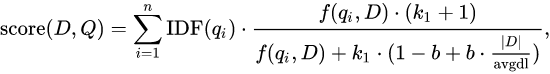

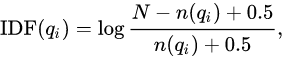

$f(q_i,D)$ частота взаимодейтсвия пользоватей с товаром $q_i$ в строке $D$ матрицы $item-user$    
$|D|$  длина строки (количество пользователей, т.е. количество столбцов в матрице $item-user$)   
$avgdl$ — средняя длина строки. В нашем случае она финсирована и вседа равна $|D|$        
k и b — свободные коэффициенты, обычно их выбирают как k = 2.0 и b = 0.75. 


   
   
Источники:   
https://habr.com/ru/post/162937/   
https://ru.wikipedia.org/wiki/Okapi_BM25   

__Как сделать рекомендацию на основе bm25__

Пришел в голову такой вариант:   
Делаем N случайных рекомендация, и на матрице $item-user$ через bm25, находим лучшего пользователя которому это подходит.   

Или такой:   
Пусть пользователю U, мы делаем 5 случайных рекомендаци. Эти рекомендации мы взвешиваем на матрице $item-user$. Далее любым оптимизационным алгоритмом(генетический, имитация отжиги и т.д.), находим лучшую случайную рекомендацию.   
___
Проблемы этого алгоритма, в том ничего не предсказывает. Он покажет какие товары пользователь уже купил, и именно это порекомендует.   
Другое дело что мы через определённые товары захотим найти пользователя который это купил. 



__Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?__   
Удалось только найти модификации такие как bm11 и bm15   


## Практическая часть


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix
from scipy import stats

# Матричная факторизация
import implicit
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)

In [3]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [4]:
data = pd.read_csv('../data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

data['norm_retail_disc'] =  (data['retail_disc']-data['retail_disc'].min())/(data['retail_disc'].max() - data['retail_disc'].min())
data['week_no_52'] =  data['week_no'] % 52
data['week_no_52'] =  (data['week_no_52']-data['week_no_52'].min())/(data['week_no_52'].max() - data['week_no_52'].min())

data['sec_trans_time'] = (60*data['trans_time'].astype(int)/100 + data['trans_time'] % 100)*60
data['sec_trans_time'] =  (data['sec_trans_time']-data['sec_trans_time'].min())/(data['sec_trans_time'].max() - data['week_no_52'].min()).astype(float)

test_size_weeks = 3
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]



In [5]:
item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

In [38]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [8]:

user_item_matrix_quantity = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', aggfunc='count', 
                                  fill_value=0).astype(float)

user_item_matrix_norm_retail_disc = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='norm_retail_disc', aggfunc='mean', 
                                  fill_value=0).astype(float)

user_item_matrix_week_no_52 = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='week_no_52', aggfunc='mean', 
                                  fill_value=0).astype(float)

user_item_matrix_sec_trans_time = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sec_trans_time', aggfunc=lambda x : stats.mode(x)[0], 
                                  fill_value=0).astype(float)


In [9]:
userids = user_item_matrix_quantity.index.values
itemids = user_item_matrix_quantity.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [15]:
!export OPENBLAS_NUM_THREADS=1

In [30]:

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

def CheckWeight(model, user_item_matrix, valid):
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    model.fit(csr_matrix(user_item_matrix).T, show_progress=False)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                            user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                            N=5, # кол-во рекомендаций 
                            filter_already_liked_items=False, 
                            filter_items=None, 
                            recalculate_user=True)
    valid['als'] = valid['user_id'].apply(lambda x: get_recommendations(x, model=model, sparse_user_item=sparse_user_item, N=5))
    return valid.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()


In [11]:
lst_user_item_matrix = [user_item_matrix_quantity, user_item_matrix_norm_retail_disc, 
user_item_matrix_week_no_52, user_item_matrix_sec_trans_time]

In [12]:
%%time
res = []

for uim in lst_user_item_matrix:
    res.append(CheckWeight(model, uim, result))
    


CPU times: user 5min 37s, sys: 3min 36s, total: 9min 13s
Wall time: 1min 34s


In [13]:
columns=['quantity', 'retail_disc', 'week_no_52', 'sec_trans_time']
for c,r in zip(columns, res):
    print(c,'\t', r)

quantity 	 0.16317335945151815
retail_disc 	 0.1843290891283056
week_no_52 	 0.18207639569049952
sec_trans_time 	 0.17394711067580806


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [42]:
import collections
import time




BestModel = collections.namedtuple('BestModel', ['model', 'score_valid', 'score_test', 'param','time'])
params = {
   'factors' : [25, 50, 75, 100, 300],
   'regularization' : [1, 0.1, 0.01, 0.05, 0.001]
}
best_model = BestModel(model=None, score_valid=0, score_test=0, param=None, time=0)

In [43]:
%%time
models=[]
for f in params['factors']:
    for r in params['regularization']:
        start_time = time.time()
        model = AlternatingLeastSquares(factors=f, #k
                                        regularization=r,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=4)
        score_valid = CheckWeight(model,user_item_matrix_norm_retail_disc,result)
        score_test = CheckWeight(model,user_item_matrix_norm_retail_disc,result_train)
        tm = (time.time() - start_time)
        models.append(BestModel(model, score_valid, score_test,
                                {'factors' : f, 'regularization' : r}, tm))
        if best_model.score_valid < score_valid:
            best_model = models[-1]
        print(f'Checked: factors={f} regularization={r}')

Checked: factors=25 regularization=1
Checked: factors=25 regularization=0.1
Checked: factors=25 regularization=0.01
Checked: factors=25 regularization=0.05
Checked: factors=25 regularization=0.001
Checked: factors=50 regularization=1
Checked: factors=50 regularization=0.1
Checked: factors=50 regularization=0.01
Checked: factors=50 regularization=0.05
Checked: factors=50 regularization=0.001
Checked: factors=75 regularization=1
Checked: factors=75 regularization=0.1
Checked: factors=75 regularization=0.01
Checked: factors=75 regularization=0.05
Checked: factors=75 regularization=0.001
Checked: factors=100 regularization=1
Checked: factors=100 regularization=0.1
Checked: factors=100 regularization=0.01
Checked: factors=100 regularization=0.05
Checked: factors=100 regularization=0.001
Checked: factors=300 regularization=1
Checked: factors=300 regularization=0.1
Checked: factors=300 regularization=0.01
Checked: factors=300 regularization=0.05
Checked: factors=300 regularization=0.001
CPU t

In [48]:
best_model.param

{'factors': 50, 'regularization': 1}

In [49]:
best_model.score_valid

0.19500489715964742

In [50]:
import matplotlib.pyplot as plt

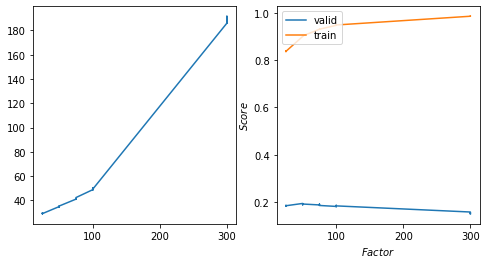

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8, 4))
vscores = np.array([m.score_valid for m in models])
tscores = np.array([m.score_test for m in models])
times = np.array([m.time for m in models])
param = np.array([m.param['factors'] for m in models])
ax[0].plot(param, times)
ax[1].plot(param,vscores,label="valid")
ax[1].plot(param,tscores,label="train")
ax[1].set_xlabel('$Factor$')
ax[1].set_ylabel('$Score$')
ax[1].legend(loc="upper left")
plt.show()

__Выводы__   

1) Веса могут сильно влияться на ALS модель. Т.е. задача сводится к фиче-инженирингу.   
2) С увеличением параметра модели _factors_ время возрастает по экспоненте. Хотя из формулы кажется что должна быть линейная зависимоть, но всё таки перемножение векторов на CPU дело не очень быстрое. На GPU возможно было бы быстрее.   
3) Очень большая разница между тренировачным и тестовым скором. Это прям расстраивает. И модель видится нежизнеспособной.     